In [1]:
import numpy as np
import os
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns


# Data Loading and Preprocessing

In [2]:
# Set the directories
surf_dir = '../data/Surf/'
cafN_dir = '../data/CaffeNet/'

# Load SURF features
data_webcam_surf = loadmat(os.path.join(surf_dir, 'webcam.mat'))
X_webcam_surf = data_webcam_surf['fts']
y_webcam_surf = data_webcam_surf['labels'].flatten()

data_dslr_surf = loadmat(os.path.join(surf_dir, 'dslr.mat'))
X_dslr_surf = data_dslr_surf['fts']
y_dslr_surf = data_dslr_surf['labels'].flatten()

# Load CaffeNet features
data_webcam_caf = loadmat(os.path.join(cafN_dir, 'webcam.mat'))
X_webcam_caf = data_webcam_caf['fts']
y_webcam_caf = data_webcam_caf['labels'].flatten()

data_dslr_caf = loadmat(os.path.join(cafN_dir, 'dslr.mat'))
X_dslr_caf = data_dslr_caf['fts']
y_dslr_caf = data_dslr_caf['labels'].flatten()


In [3]:
def standardize_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

X_webcam_surf = standardize_data(X_webcam_surf)
X_dslr_surf = standardize_data(X_dslr_surf)
X_webcam_caf = standardize_data(X_webcam_caf)
X_dslr_caf = standardize_data(X_dslr_caf)


In [4]:
def handle_class_imbalance(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# Apply SMOTE only on the source domain
X_webcam_surf_resampled, y_webcam_surf_resampled = handle_class_imbalance(X_webcam_surf, y_webcam_surf)
X_webcam_caf_resampled, y_webcam_caf_resampled = handle_class_imbalance(X_webcam_caf, y_webcam_caf)

# Do not apply SMOTE on the target domain
X_dslr_surf_resampled, y_dslr_surf_resampled = X_dslr_surf, y_dslr_surf
X_dslr_caf_resampled, y_dslr_caf_resampled = X_dslr_caf, y_dslr_caf

In [5]:
from sklearn.ensemble import IsolationForest

# Modify remove_outliers function to return both cleaned data and mask
def remove_outliers(X):
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    y_pred = iso_forest.fit_predict(X)
    mask = y_pred != -1
    X_clean = X[mask]
    return X_clean, mask

# For SURF
# Apply to source data only
X_webcam_surf_clean, mask = remove_outliers(X_webcam_surf_resampled)
y_webcam_surf_clean = y_webcam_surf_resampled[mask]  # Adjust labels accordingly

# Do not remove outliers from target data unless necessary
X_dslr_surf_clean = X_dslr_surf_resampled
y_dslr_surf_clean = y_dslr_surf_resampled

# For CaffeNet
# Apply to source data only
X_webcam_caf_clean, mask = remove_outliers(X_webcam_caf_resampled)
y_webcam_caf_clean = y_webcam_caf_resampled[mask]  # Adjust labels accordingly

# Do not remove outliers from target data unless necessary
X_dslr_caf_clean = X_dslr_caf_resampled
y_dslr_caf_clean = y_dslr_caf_resampled

# Firtst Approach

In [6]:
def subspace_alignment_method(S, T, y_S, y_T_true, d):
    # Step 1: Compute d principal components for source and target
    pca_source = PCA(n_components=d)
    pca_source.fit(S)
    Xs = pca_source.components_  # Shape: (d, D)

    pca_target = PCA(n_components=d)
    pca_target.fit(T)
    Xt = pca_target.components_  # Shape: (d, D)

    # Step 2: Project source and target data
    S_hat = pca_source.transform(S)  # Shape: (n_samples_source, d)
    T_hat = pca_target.transform(T)  # Shape: (n_samples_target, d)

    # Step 3: Compute alignment matrix
    M = np.dot(Xs, Xt.T)  # Shape: (d, d)

    # Step 4: Align the source data
    S_hat_p = np.dot(S_hat, M)  # Shape: (n_samples_source, d)

    # Step 5: Predict labels of T_hat using 1-NN classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(S_hat_p, y_S)
    y_pred = knn.predict(T_hat)

    # Compute accuracy
    accuracy = accuracy_score(y_T_true, y_pred)

    return accuracy


In [7]:
def cross_validate_on_source(S, y_S, d_values, cv=5):
    """
    Perform cross-validation on the source domain to select the optimal d.

    Args:
    - S: Source data matrix of shape (n_samples_source, n_features)
    - y_S: Source labels of shape (n_samples_source,)
    - d_values: List of candidate values for the number of principal components
    - cv: Number of cross-validation folds

    Returns:
    - best_d: Optimal number of principal components based on validation accuracy
    - cv_results: Dictionary containing validation accuracies for each d
    """
    cv_results = {}
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for d in d_values:
        val_accuracies = []
        for train_index, val_index in kf.split(S):
            S_train, S_val = S[train_index], S[val_index]
            y_S_train, y_S_val = y_S[train_index], y_S[val_index]

            # Perform PCA on S_train
            pca_source = PCA(n_components=d)
            pca_source.fit(S_train)
            Xs_train = pca_source.components_.T

            # Project S_train and S_val
            S_hat_train = np.dot(S_train, Xs_train)
            S_hat_val = np.dot(S_val, Xs_train)

            # Train 1-NN classifier
            knn = KNeighborsClassifier(n_neighbors=1)
            knn.fit(S_hat_train, y_S_train)

            # Predict on validation set
            y_val_pred = knn.predict(S_hat_val)
            val_acc = accuracy_score(y_S_val, y_val_pred)
            val_accuracies.append(val_acc)

        avg_val_acc = np.mean(val_accuracies)
        cv_results[d] = avg_val_acc
        print(f"d={d}, Cross-Validation Accuracy: {avg_val_acc:.4f}")

    # Select the d with the highest average validation accuracy
    best_d = max(cv_results, key=cv_results.get)
    print(f"\nOptimal number of components selected: d={best_d}")
    return best_d, cv_results


In [8]:
d_values_surf = range(10, 51, 1)  # Candidate values for d
S_surf = X_webcam_surf_clean
y_S_surf = y_webcam_surf_clean

print("Cross-Validation on Source Domain (SURF Features):")
best_d_surf, cv_results_surf = cross_validate_on_source(S_surf, y_S_surf, d_values_surf)


Cross-Validation on Source Domain (SURF Features):
d=10, Cross-Validation Accuracy: 0.8503
d=11, Cross-Validation Accuracy: 0.8505
d=12, Cross-Validation Accuracy: 0.8701
d=13, Cross-Validation Accuracy: 0.8628
d=14, Cross-Validation Accuracy: 0.8774
d=15, Cross-Validation Accuracy: 0.8726
d=16, Cross-Validation Accuracy: 0.8872
d=17, Cross-Validation Accuracy: 0.8871
d=18, Cross-Validation Accuracy: 0.9043
d=19, Cross-Validation Accuracy: 0.8896
d=20, Cross-Validation Accuracy: 0.8896
d=21, Cross-Validation Accuracy: 0.8699
d=22, Cross-Validation Accuracy: 0.8748
d=23, Cross-Validation Accuracy: 0.8797
d=24, Cross-Validation Accuracy: 0.8870
d=25, Cross-Validation Accuracy: 0.8797
d=26, Cross-Validation Accuracy: 0.8870
d=27, Cross-Validation Accuracy: 0.8772
d=28, Cross-Validation Accuracy: 0.8796
d=29, Cross-Validation Accuracy: 0.8748
d=30, Cross-Validation Accuracy: 0.8674
d=31, Cross-Validation Accuracy: 0.8699
d=32, Cross-Validation Accuracy: 0.8626
d=33, Cross-Validation Accura

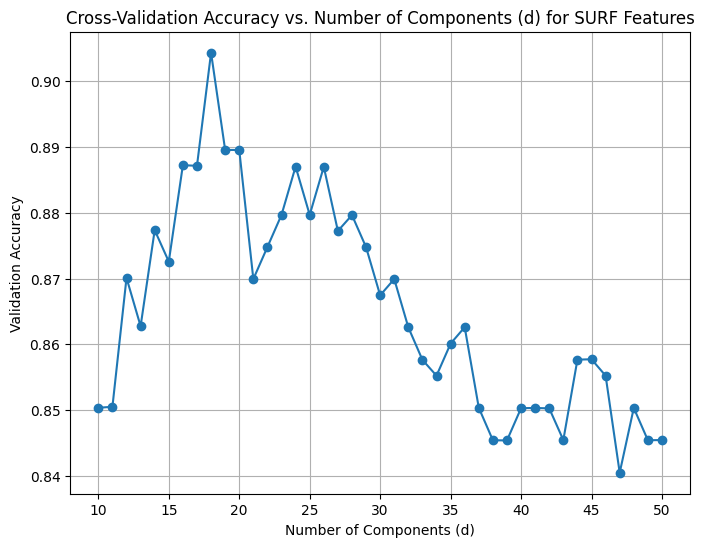

In [9]:
# Plot validation accuracy vs. d
plt.figure(figsize=(8, 6))
plt.plot(list(cv_results_surf.keys()), list(cv_results_surf.values()), marker='o')
plt.title('Cross-Validation Accuracy vs. Number of Components (d) for SURF Features')
plt.xlabel('Number of Components (d)')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()


In [10]:
d_values_caf = range(10, 60, 1)  # Candidate values for d
S_caf = X_webcam_caf_clean
y_S_caf = y_webcam_caf_clean

print("Cross-Validation on Source Domain (CaffeNet Features):")
best_d_caf, cv_results_caf = cross_validate_on_source(S_caf, y_S_caf, d_values_caf)


Cross-Validation on Source Domain (CaffeNet Features):
d=10, Cross-Validation Accuracy: 0.9877
d=11, Cross-Validation Accuracy: 0.9927
d=12, Cross-Validation Accuracy: 0.9927
d=13, Cross-Validation Accuracy: 0.9927
d=14, Cross-Validation Accuracy: 0.9927
d=15, Cross-Validation Accuracy: 0.9902
d=16, Cross-Validation Accuracy: 0.9927
d=17, Cross-Validation Accuracy: 0.9927
d=18, Cross-Validation Accuracy: 0.9927
d=19, Cross-Validation Accuracy: 0.9927
d=20, Cross-Validation Accuracy: 0.9951
d=21, Cross-Validation Accuracy: 0.9927
d=22, Cross-Validation Accuracy: 0.9927
d=23, Cross-Validation Accuracy: 0.9902
d=24, Cross-Validation Accuracy: 0.9927
d=25, Cross-Validation Accuracy: 0.9927
d=26, Cross-Validation Accuracy: 0.9951
d=27, Cross-Validation Accuracy: 0.9951
d=28, Cross-Validation Accuracy: 0.9951
d=29, Cross-Validation Accuracy: 0.9976
d=30, Cross-Validation Accuracy: 0.9976
d=31, Cross-Validation Accuracy: 0.9976
d=32, Cross-Validation Accuracy: 0.9976
d=33, Cross-Validation Ac

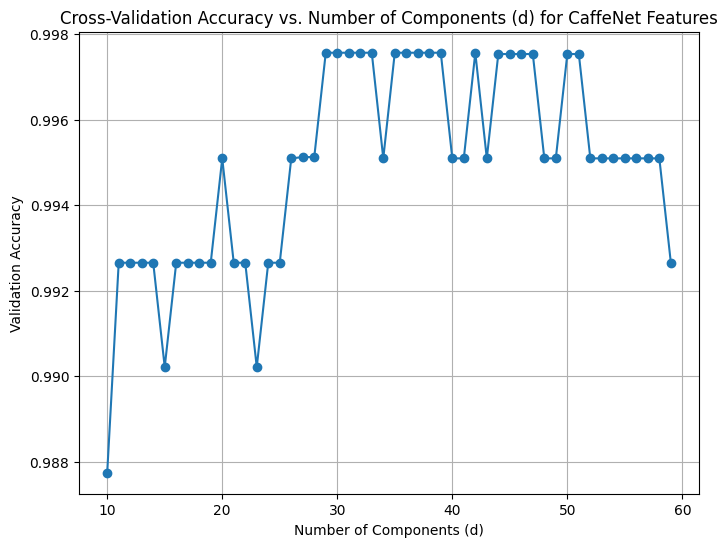

In [11]:
# Plot validation accuracy vs. d
plt.figure(figsize=(8, 6))
plt.plot(list(cv_results_caf.keys()), list(cv_results_caf.values()), marker='o')
plt.title('Cross-Validation Accuracy vs. Number of Components (d) for CaffeNet Features')
plt.xlabel('Number of Components (d)')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()


In [12]:
# Set the optimal d for SURF features
d_surf = best_d_surf
S_surf = X_webcam_surf_clean
T_surf = X_dslr_surf_clean
y_S_surf = y_webcam_surf_clean
y_T_surf_true = y_dslr_surf_clean

# Perform subspace alignment and evaluate
accuracy_surf = subspace_alignment_method(S_surf, T_surf, y_S_surf, y_T_surf_true, d_surf)
print(f"\nSubspace Alignment Accuracy on SURF DSLR Dataset with d={d_surf}: {accuracy_surf:.4f}")

# Baseline: 1-NN without projection
knn_baseline_surf = KNeighborsClassifier(n_neighbors=1)
knn_baseline_surf.fit(S_surf, y_S_surf)
y_pred_baseline_surf = knn_baseline_surf.predict(T_surf)
accuracy_baseline_surf = accuracy_score(y_T_surf_true, y_pred_baseline_surf)
print(f"Baseline Accuracy on SURF DSLR Dataset without Projection: {accuracy_baseline_surf:.4f}")



Subspace Alignment Accuracy on SURF DSLR Dataset with d=18: 0.7134
Baseline Accuracy on SURF DSLR Dataset without Projection: 0.4268


In [13]:
# Set the optimal d for CaffeNet features
d_caf = best_d_caf
S_caf = X_webcam_caf_clean
T_caf = X_dslr_caf_clean
y_S_caf = y_webcam_caf_clean
y_T_caf_true = y_dslr_caf_clean

# Perform subspace alignment and evaluate
accuracy_caf = subspace_alignment_method(S_caf, T_caf, y_S_caf, y_T_caf_true, d_caf)
print(f"\nSubspace Alignment Accuracy on CaffeNet DSLR Dataset with d={d_caf}: {accuracy_caf:.4f}")

# Baseline: 1-NN without projection
knn_baseline_caf = KNeighborsClassifier(n_neighbors=1)
knn_baseline_caf.fit(S_caf, y_S_caf)
y_pred_baseline_caf = knn_baseline_caf.predict(T_caf)
accuracy_baseline_caf = accuracy_score(y_T_caf_true, y_pred_baseline_caf)
print(f"Baseline Accuracy on CaffeNet DSLR Dataset without Projection: {accuracy_baseline_caf:.4f}")



Subspace Alignment Accuracy on CaffeNet DSLR Dataset with d=29: 1.0000
Baseline Accuracy on CaffeNet DSLR Dataset without Projection: 1.0000


In [14]:
# SURF Features Results
print(f"\nSURF Features Results:")
print(f"Baseline Accuracy: {accuracy_baseline_surf:.4f}")
print(f"Subspace Alignment Accuracy: {accuracy_surf:.4f}")

# CaffeNet Features Results
print(f"\nCaffeNet Features Results:")
print(f"Baseline Accuracy: {accuracy_baseline_caf:.4f}")
print(f"Subspace Alignment Accuracy: {accuracy_caf:.4f}")



SURF Features Results:
Baseline Accuracy: 0.4268
Subspace Alignment Accuracy: 0.7134

CaffeNet Features Results:
Baseline Accuracy: 1.0000
Subspace Alignment Accuracy: 1.0000


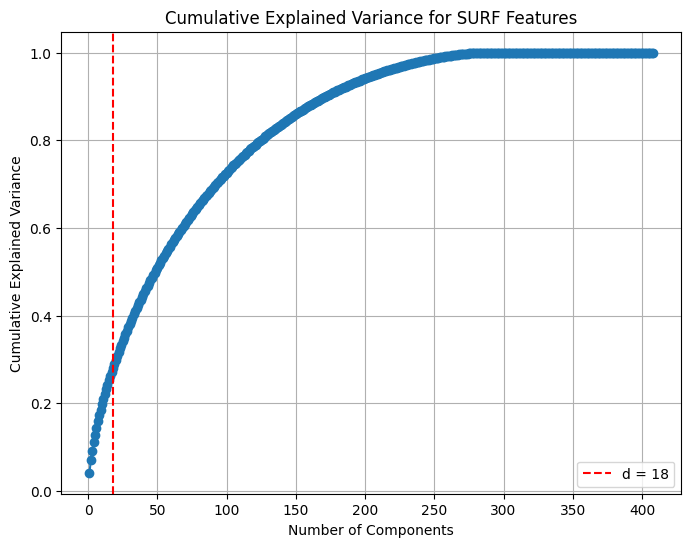

In [15]:
# PCA on source data
pca_surf = PCA().fit(S_surf)
explained_variance_surf = np.cumsum(pca_surf.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_surf) + 1), explained_variance_surf, marker='o')
plt.axvline(x=d_surf, color='r', linestyle='--', label=f'd = {d_surf}')
plt.title('Cumulative Explained Variance for SURF Features')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()


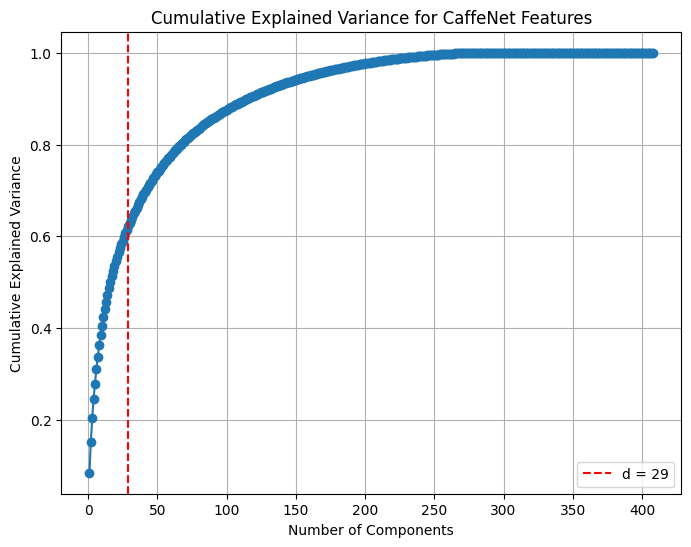

In [16]:
# PCA on source data
pca_caf = PCA().fit(S_caf)
explained_variance_caf = np.cumsum(pca_caf.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_caf) + 1), explained_variance_caf, marker='o')
plt.axvline(x=d_caf, color='r', linestyle='--', label=f'd = {d_caf}')
plt.title('Cumulative Explained Variance for CaffeNet Features')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()


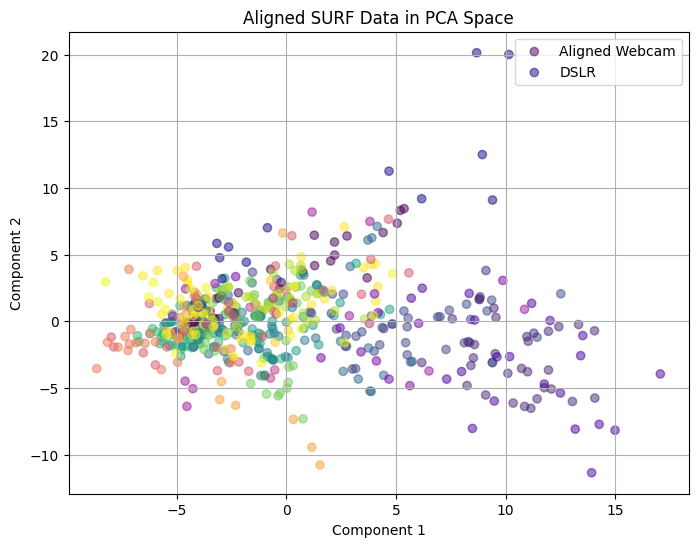

In [17]:
# Project source and target data
pca_source_surf = PCA(n_components=d_surf)
S_hat_surf = pca_source_surf.fit_transform(S_surf)

pca_target_surf = PCA(n_components=d_surf)
T_hat_surf = pca_target_surf.fit_transform(T_surf)

# Compute alignment matrix
Xs_surf = pca_source_surf.components_  # Shape: (d, D)
Xt_surf = pca_target_surf.components_  # Shape: (d, D)
M_surf = np.dot(Xs_surf, Xt_surf.T)    # Shape: (d, d)

# Align source data
S_hat_p_surf = np.dot(S_hat_surf, M_surf)  # Shape: (n_samples, d)

# Plot aligned source and target data
plt.figure(figsize=(8, 6))
plt.scatter(S_hat_p_surf[:, 0], S_hat_p_surf[:, 1], c=y_S_surf, cmap='viridis', alpha=0.5, label='Aligned Webcam')
plt.scatter(T_hat_surf[:, 0], T_hat_surf[:, 1], c=y_T_surf_true, cmap='plasma', alpha=0.5, label='DSLR')
plt.title('Aligned SURF Data in PCA Space')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()


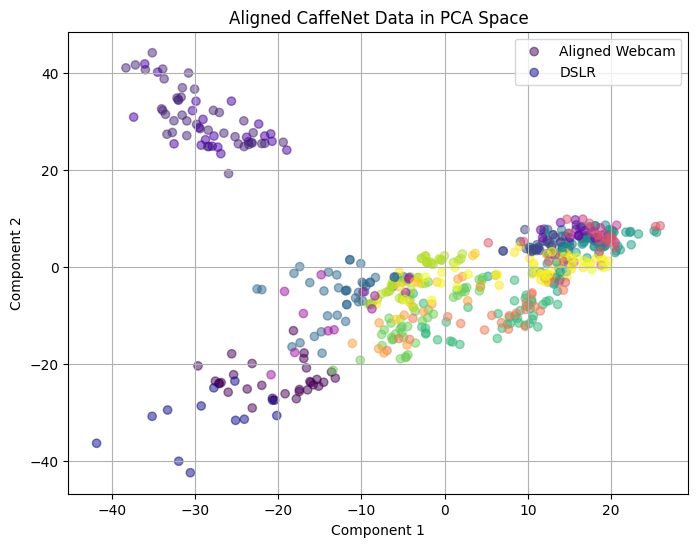

In [18]:
# Project source and target data
pca_source_caf = PCA(n_components=d_caf)
S_hat_caf = pca_source_caf.fit_transform(S_caf)

pca_target_caf = PCA(n_components=d_caf)
T_hat_caf = pca_target_caf.fit_transform(T_caf)

# Compute alignment matrix
Xs_caf = pca_source_caf.components_      # Shape: (d, D)
Xt_caf = pca_target_caf.components_      # Shape: (d, D)
M_caf = np.dot(Xs_caf, Xt_caf.T)         # Shape: (d, d)

# Align source data
S_hat_p_caf = np.dot(S_hat_caf, M_caf)   # Shape: (n_samples, d)

# Plot aligned source and target data
plt.figure(figsize=(8, 6))
plt.scatter(S_hat_p_caf[:, 0], S_hat_p_caf[:, 1], c=y_S_caf, cmap='viridis', alpha=0.5, label='Aligned Webcam')
plt.scatter(T_hat_caf[:, 0], T_hat_caf[:, 1], c=y_T_caf_true, cmap='plasma', alpha=0.5, label='DSLR')
plt.title('Aligned CaffeNet Data in PCA Space')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
def verify_shapes():
    datasets = {
        'SURF Webcam': X_webcam_surf_clean,
        'SURF DSLR': X_dslr_surf_clean,
        'CaffeNet Webcam': X_webcam_caf_clean,
        'CaffeNet DSLR': X_dslr_caf_clean
    }
    for name, data in datasets.items():
        print(f"{name} shape: {data.shape}")

verify_shapes()


SURF Webcam shape: (408, 800)
SURF DSLR shape: (157, 800)
CaffeNet Webcam shape: (408, 4096)
CaffeNet DSLR shape: (157, 4096)


In [20]:
def verify_pca_and_alignment(S, T, d):
    pca_source = PCA(n_components=d).fit(S)
    pca_target = PCA(n_components=d).fit(T)
    Xs = pca_source.components_.T
    Xt = pca_target.components_.T
    M = np.dot(Xs.T, Xt)
    print(f"PCA components shape: {Xs.shape}")
    print(f"Alignment matrix shape: {M.shape}")

print("\nVerifying shapes for SURF features:")
verify_pca_and_alignment(S_surf, T_surf, d_surf)

print("\nVerifying shapes for CaffeNet features:")
verify_pca_and_alignment(S_caf, T_caf, d_caf)



Verifying shapes for SURF features:
PCA components shape: (800, 18)
Alignment matrix shape: (18, 18)

Verifying shapes for CaffeNet features:
PCA components shape: (4096, 29)
Alignment matrix shape: (29, 29)


In [21]:
print("SURF Features:")
print(f"S_hat_surf shape: {S_hat_surf.shape}")          # Should be (n_samples, d)
print(f"T_hat_surf shape: {T_hat_surf.shape}")          # Should be (n_samples, d)
print(f"Xs_surf shape: {Xs_surf.shape}")                # Should be (d, D)
print(f"Xt_surf shape: {Xt_surf.shape}")                # Should be (d, D)
print(f"M_surf shape: {M_surf.shape}")                  # Should be (d, d)
print(f"S_hat_p_surf shape: {S_hat_p_surf.shape}")      # Should be (n_samples, d)


SURF Features:
S_hat_surf shape: (408, 18)
T_hat_surf shape: (157, 18)
Xs_surf shape: (18, 800)
Xt_surf shape: (18, 800)
M_surf shape: (18, 18)
S_hat_p_surf shape: (408, 18)


# Second Approach

In [22]:
def select_d_explained_variance(X, variance_threshold=0.80):
    pca = PCA().fit(X)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumulative_variance >= variance_threshold) + 1
    return d, cumulative_variance

# Select d for SURF features
d_surf, cumulative_variance_surf = select_d_explained_variance(X_webcam_surf_clean, variance_threshold=0.80)
print(f"Selected number of components for SURF features: d_surf = {d_surf}")

# Select d for CaffeNet features
d_caf, cumulative_variance_caf = select_d_explained_variance(X_webcam_caf_clean, variance_threshold=0.80)
print(f"Selected number of components for CaffeNet features: d_caf = {d_caf}")


Selected number of components for SURF features: d_surf = 125
Selected number of components for CaffeNet features: d_caf = 68


In [23]:
def subspace_alignment_method(S, T, y_S, d):
    # Step 1: Compute d principal components for source and target
    pca_source = PCA(n_components=d)
    S_hat = pca_source.fit_transform(S)  # Shape: (n_samples_source, d)
    Xs = pca_source.components_.T         # Shape: (n_features, d)

    pca_target = PCA(n_components=d)
    T_hat = pca_target.fit_transform(T)  # Shape: (n_samples_target, d)
    Xt = pca_target.components_.T        # Shape: (n_features, d)

    # Step 2: Compute alignment matrix
    M = np.dot(Xs.T, Xt)

    # Step 3: Align the source data
    S_hat_p = np.dot(S_hat, M)  # Shape: (n_samples_source, d)

    # Step 4: Train classifier on aligned source data
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(S_hat_p, y_S)

    # Step 5: Project target data
    T_hat_p = T_hat  # Target data remains in its PCA space

    # Step 6: Predict labels of T_hat_p
    y_pred = knn.predict(T_hat_p)

    return y_pred


In [24]:
# Prepare data
S_surf = X_webcam_surf_clean
T_surf = X_dslr_surf_clean
y_S_surf = y_webcam_surf_clean
y_T_surf_true = y_dslr_surf_clean  # Used only for evaluation

# Perform subspace alignment and predict
y_pred_surf = subspace_alignment_method(S_surf, T_surf, y_S_surf, d_surf)

# Compute accuracy
accuracy_surf = accuracy_score(y_T_surf_true, y_pred_surf)
print(f"\nSubspace Alignment Accuracy on SURF DSLR Dataset with d={d_surf}: {accuracy_surf:.4f}")

# Baseline: 1-NN without projection
knn_baseline_surf = KNeighborsClassifier(n_neighbors=1)
knn_baseline_surf.fit(S_surf, y_S_surf)
y_pred_baseline_surf = knn_baseline_surf.predict(T_surf)
accuracy_baseline_surf = accuracy_score(y_T_surf_true, y_pred_baseline_surf)
print(f"Baseline Accuracy on SURF DSLR Dataset without Projection: {accuracy_baseline_surf:.4f}")



Subspace Alignment Accuracy on SURF DSLR Dataset with d=125: 0.8726
Baseline Accuracy on SURF DSLR Dataset without Projection: 0.4268


In [25]:
# Prepare data
S_caf = X_webcam_caf_clean
T_caf = X_dslr_caf_clean
y_S_caf = y_webcam_caf_clean
y_T_caf_true = y_dslr_caf_clean  # Used only for evaluation

# Perform subspace alignment and predict
y_pred_caf = subspace_alignment_method(S_caf, T_caf, y_S_caf, d_caf)

# Compute accuracy
accuracy_caf = accuracy_score(y_T_caf_true, y_pred_caf)
print(f"\nSubspace Alignment Accuracy on CaffeNet DSLR Dataset with d={d_caf}: {accuracy_caf:.4f}")

# Baseline: 1-NN without projection
knn_baseline_caf = KNeighborsClassifier(n_neighbors=1)
knn_baseline_caf.fit(S_caf, y_S_caf)
y_pred_baseline_caf = knn_baseline_caf.predict(T_caf)
accuracy_baseline_caf = accuracy_score(y_T_caf_true, y_pred_baseline_caf)
print(f"Baseline Accuracy on CaffeNet DSLR Dataset without Projection: {accuracy_baseline_caf:.4f}")



Subspace Alignment Accuracy on CaffeNet DSLR Dataset with d=68: 0.9936
Baseline Accuracy on CaffeNet DSLR Dataset without Projection: 1.0000


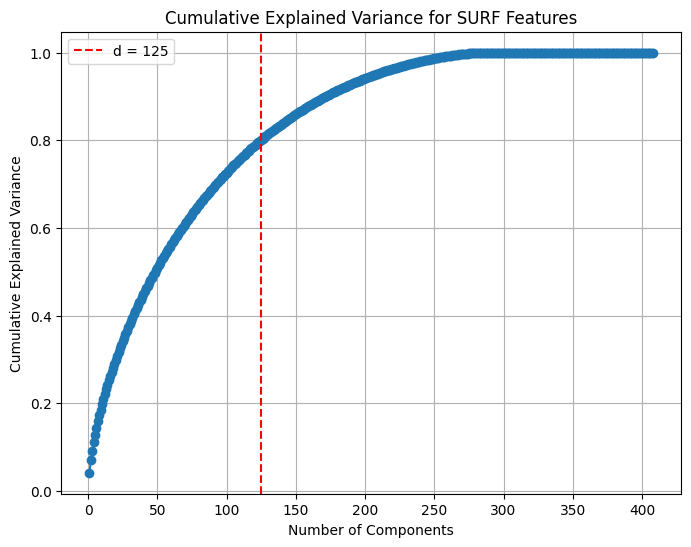

In [26]:
# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_surf) + 1), cumulative_variance_surf, marker='o')
plt.axvline(x=d_surf, color='r', linestyle='--', label=f'd = {d_surf}')
plt.title('Cumulative Explained Variance for SURF Features')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()


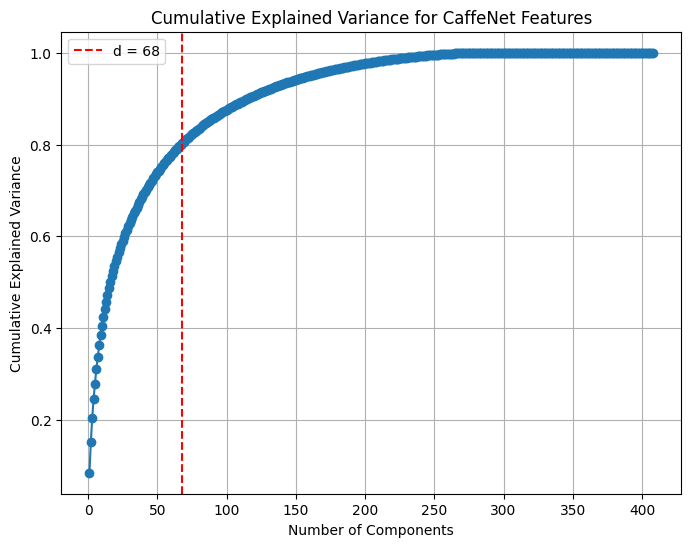

In [27]:
# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_caf) + 1), cumulative_variance_caf, marker='o')
plt.axvline(x=d_caf, color='r', linestyle='--', label=f'd = {d_caf}')
plt.title('Cumulative Explained Variance for CaffeNet Features')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()


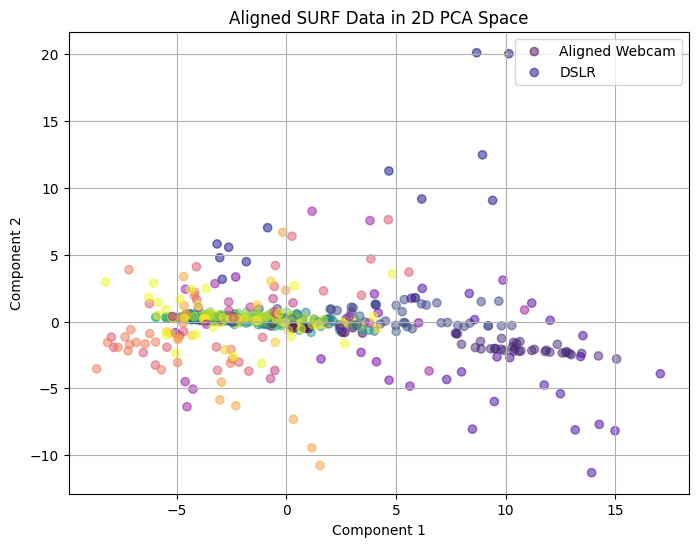

In [28]:
# Project and align data
pca_source_surf = PCA(n_components=2).fit(S_surf)
S_hat_surf_2d = pca_source_surf.transform(S_surf)
pca_target_surf = PCA(n_components=2).fit(T_surf)
T_hat_surf_2d = pca_target_surf.transform(T_surf)

Xs_surf = pca_source_surf.components_.T
Xt_surf = pca_target_surf.components_.T
M_surf = np.dot(Xs_surf.T, Xt_surf)

S_hat_p_surf_2d = np.dot(S_hat_surf_2d, M_surf)

# Plot aligned data
plt.figure(figsize=(8, 6))
plt.scatter(S_hat_p_surf_2d[:, 0], S_hat_p_surf_2d[:, 1], c=y_S_surf, cmap='viridis', alpha=0.5, label='Aligned Webcam')
plt.scatter(T_hat_surf_2d[:, 0], T_hat_surf_2d[:, 1], c=y_T_surf_true, cmap='plasma', alpha=0.5, label='DSLR')
plt.title('Aligned SURF Data in 2D PCA Space')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()


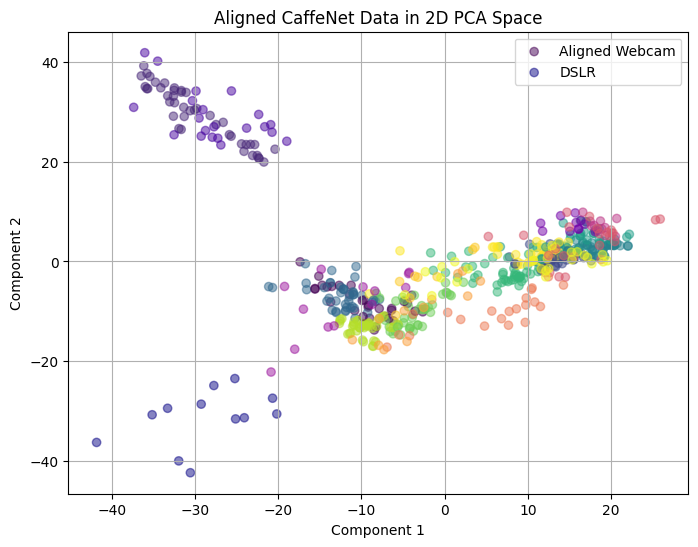

In [29]:
# Project and align data
pca_source_caf = PCA(n_components=2).fit(S_caf)
S_hat_caf_2d = pca_source_caf.transform(S_caf)
pca_target_caf = PCA(n_components=2).fit(T_caf)
T_hat_caf_2d = pca_target_caf.transform(T_caf)

Xs_caf = pca_source_caf.components_.T
Xt_caf = pca_target_caf.components_.T
M_caf = np.dot(Xs_caf.T, Xt_caf)

S_hat_p_caf_2d = np.dot(S_hat_caf_2d, M_caf)

# Plot aligned data
plt.figure(figsize=(8, 6))
plt.scatter(S_hat_p_caf_2d[:, 0], S_hat_p_caf_2d[:, 1], c=y_S_caf, cmap='viridis', alpha=0.5, label='Aligned Webcam')
plt.scatter(T_hat_caf_2d[:, 0], T_hat_caf_2d[:, 1], c=y_T_caf_true, cmap='plasma', alpha=0.5, label='DSLR')
plt.title('Aligned CaffeNet Data in 2D PCA Space')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
def verify_shapes():
    datasets = {
        'SURF Webcam': X_webcam_surf_clean,
        'SURF DSLR': X_dslr_surf_clean,
        'CaffeNet Webcam': X_webcam_caf_clean,
        'CaffeNet DSLR': X_dslr_caf_clean
    }
    for name, data in datasets.items():
        print(f"{name} shape: {data.shape}")

verify_shapes()


SURF Webcam shape: (408, 800)
SURF DSLR shape: (157, 800)
CaffeNet Webcam shape: (408, 4096)
CaffeNet DSLR shape: (157, 4096)


In [31]:
def verify_pca_and_alignment(S, T, d):
    pca_source = PCA(n_components=d).fit(S)
    pca_target = PCA(n_components=d).fit(T)
    Xs = pca_source.components_.T  # Shape: (n_features, d)
    Xt = pca_target.components_.T  # Shape: (n_features, d)
    M = np.dot(Xs.T, Xt)           # Shape: (d, d)
    print(f"PCA components shape: {Xs.shape}")
    print(f"Alignment matrix shape: {M.shape}")

print("\nVerifying shapes for SURF features:")
verify_pca_and_alignment(S_surf, T_surf, d_surf)

print("\nVerifying shapes for CaffeNet features:")
verify_pca_and_alignment(S_caf, T_caf, d_caf)



Verifying shapes for SURF features:
PCA components shape: (800, 125)
Alignment matrix shape: (125, 125)

Verifying shapes for CaffeNet features:
PCA components shape: (4096, 68)
Alignment matrix shape: (68, 68)


In [32]:
# SURF Features Results
print(f"\nSURF Features Results:")
print(f"Baseline Accuracy: {accuracy_baseline_surf:.4f}")
print(f"Subspace Alignment Accuracy: {accuracy_surf:.4f}")

# CaffeNet Features Results
print(f"\nCaffeNet Features Results:")
print(f"Baseline Accuracy: {accuracy_baseline_caf:.4f}")
print(f"Subspace Alignment Accuracy: {accuracy_caf:.4f}")



SURF Features Results:
Baseline Accuracy: 0.4268
Subspace Alignment Accuracy: 0.8726

CaffeNet Features Results:
Baseline Accuracy: 1.0000
Subspace Alignment Accuracy: 0.9936


In [33]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix for baseline
print("CaffeNet Baseline Confusion Matrix:")
cm_baseline_caf = confusion_matrix(y_T_caf_true, y_pred_baseline_caf)
print(cm_baseline_caf)

# Classification report
print("\nCaffeNet Baseline Classification Report:")
print(classification_report(y_T_caf_true, y_pred_baseline_caf))

# Confusion matrix for subspace alignment
print("CaffeNet Subspace Alignment Confusion Matrix:")
cm_caf = confusion_matrix(y_T_caf_true, y_pred_caf)
print(cm_caf)

# Classification report
print("\nCaffeNet Subspace Alignment Classification Report:")
print(classification_report(y_T_caf_true, y_pred_caf))


CaffeNet Baseline Confusion Matrix:
[[12  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0 24  0  0  0  0]
 [ 0  0  0  0  0  0 22  0  0  0]
 [ 0  0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  0  0 23]]

CaffeNet Baseline Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00       

In [34]:
# Check for overlapping samples
X_webcam_caf_clean_contiguous = np.ascontiguousarray(X_webcam_caf_clean)
X_dslr_caf_clean_contiguous = np.ascontiguousarray(X_dslr_caf_clean)

overlap = np.intersect1d(X_webcam_caf_clean_contiguous.view([('', X_webcam_caf_clean_contiguous.dtype)] * X_webcam_caf_clean_contiguous.shape[1]),
                         X_dslr_caf_clean_contiguous.view([('', X_dslr_caf_clean_contiguous.dtype)] * X_dslr_caf_clean_contiguous.shape[1]))
print(f"Number of overlapping samples between Webcam and DSLR datasets: {len(overlap)}")


Number of overlapping samples between Webcam and DSLR datasets: 0
